## Setup

Load libraries:

In [1]:
import sys
sys.path.append('../') 

In [2]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt

from utils.plotting_utils import plot_var
from sklearn.metrics import mean_squared_error
from utils.validation_utils import validate_predictions

## Load Data

* In-situ Data

In [3]:
insitu_data = pd.read_csv('../data/insitu_feb_08.csv')

insitu_data.info()
insitu_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1777 entries, 0 to 1776
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   easting              1777 non-null   float64
 1   northing             1777 non-null   float64
 2   observed_snow_depth  1777 non-null   float64
dtypes: float64(3)
memory usage: 41.8 KB


,easting,northing,observed_snow_depth
0,232262.0,4327196.0,1.10
1,232262.6,4327199.0,1.09
2,232263.3,4327202.1,1.09
3,232263.9,4327205.1,1.11
4,232264.5,4327208.1,1.18


* Predicted Snow Depth (XGBoost) and Lidar Snow Depth

In [4]:
xgboost_train_pred = pd.read_csv('../results/XGBoost/AllCombined/all/train_predictions.csv')
xgboost_train_pred.info()
xgboost_train_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981587 entries, 0 to 5981586
Data columns (total 1 columns):
 #   Column           Dtype  
---  ------           -----  
 0   snow_depth_pred  float64
dtypes: float64(1)
memory usage: 45.6 MB


,snow_depth_pred
0,1.205211
1,0.790902
2,1.004301
3,0.933287
4,1.500561


In [5]:
xgboost_test_pred = pd.read_csv('../results/XGBoost/AllCombined/all/test_predictions.csv')
xgboost_test_pred.info()
xgboost_test_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664621 entries, 0 to 664620
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   snow_depth_pred  664621 non-null  float64
dtypes: float64(1)
memory usage: 5.1 MB


,snow_depth_pred
0,1.317406
1,1.455900
2,1.320729
3,0.884155
4,1.023602


In [6]:
with open('../data/full_splits.pkl', 'rb') as f:
    full_splits = pickle.load(f)

In [7]:
all_test_pred=(
    full_splits['X_test'][['idx','easting', 'northing']]
    .reset_index(drop=True)
    .assign(
        snow_depth=full_splits['y_test'].reset_index(drop=True),
        snow_depth_pred=xgboost_test_pred['snow_depth_pred']
    )
)

all_train_pred=(
    full_splits['X_temp'][['idx','easting', 'northing']]
    .reset_index(drop=True)
    .assign(
        snow_depth=full_splits['y_temp'].reset_index(drop=True),
        snow_depth_pred=xgboost_train_pred['snow_depth_pred']
    )
)

xgboost_pred=pd.concat([all_train_pred, all_test_pred], axis=0)
xgboost_pred.head()

,idx,easting,northing,snow_depth,snow_depth_pred
0,7105617,228981.856936,4.328396e+06,1.205490,1.205211
1,707495,222696.352076,4.322638e+06,0.792893,0.790902
2,7362767,220509.176400,4.328630e+06,1.004318,1.004301
3,4097011,222261.317134,4.325689e+06,0.933029,0.933287
4,3892236,227874.768013,4.325503e+06,1.500168,1.500561


## Validation

In [8]:
insitu_vs_xgboost=validate_predictions(
    predictions=xgboost_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth_pred',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

insitu_vs_lidar=validate_predictions(
    predictions=xgboost_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

In [9]:
lidar_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_lidar['observed_snow_depth'],
    y_pred=insitu_vs_lidar['snow_depth'],
    squared=False
)

xgboost_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_xgboost['observed_snow_depth'],
    y_pred=insitu_vs_xgboost['snow_depth_pred'],
    squared=False
)

print(f'RMSE of XGBoost predictions on insitu data: {xgboost_insitu_rmse*100:.3f} [cm]')
print(f'RMSE of Lidar predictions on insitu data: {lidar_insitu_rmse*100:.3f} [cm]')

RMSE of XGBoost predictions on insitu data: 16.020 [cm]
RMSE of Lidar predictions on insitu data: 15.853 [cm]


## Spatial plots

In [10]:
null_values_df=(
    pd.read_csv('../data/null_rows.csv')
    .assign(snow_depth_pred=lambda x: x.snow_depth)
)

full_data=(
    pd.concat([xgboost_pred, null_values_df], axis=0)
    .reset_index(drop=True)
    .sort_values(by='idx')
    .assign(snow_depth_diff=lambda x: abs(x.snow_depth_pred - x.snow_depth))
)

In [11]:
shape=(2333, 3333)
true_depth=full_data.snow_depth.values.reshape(shape)
predicted_depth=full_data.snow_depth_pred.values.reshape(shape)
depth_error=full_data.snow_depth_diff.values.reshape(shape)

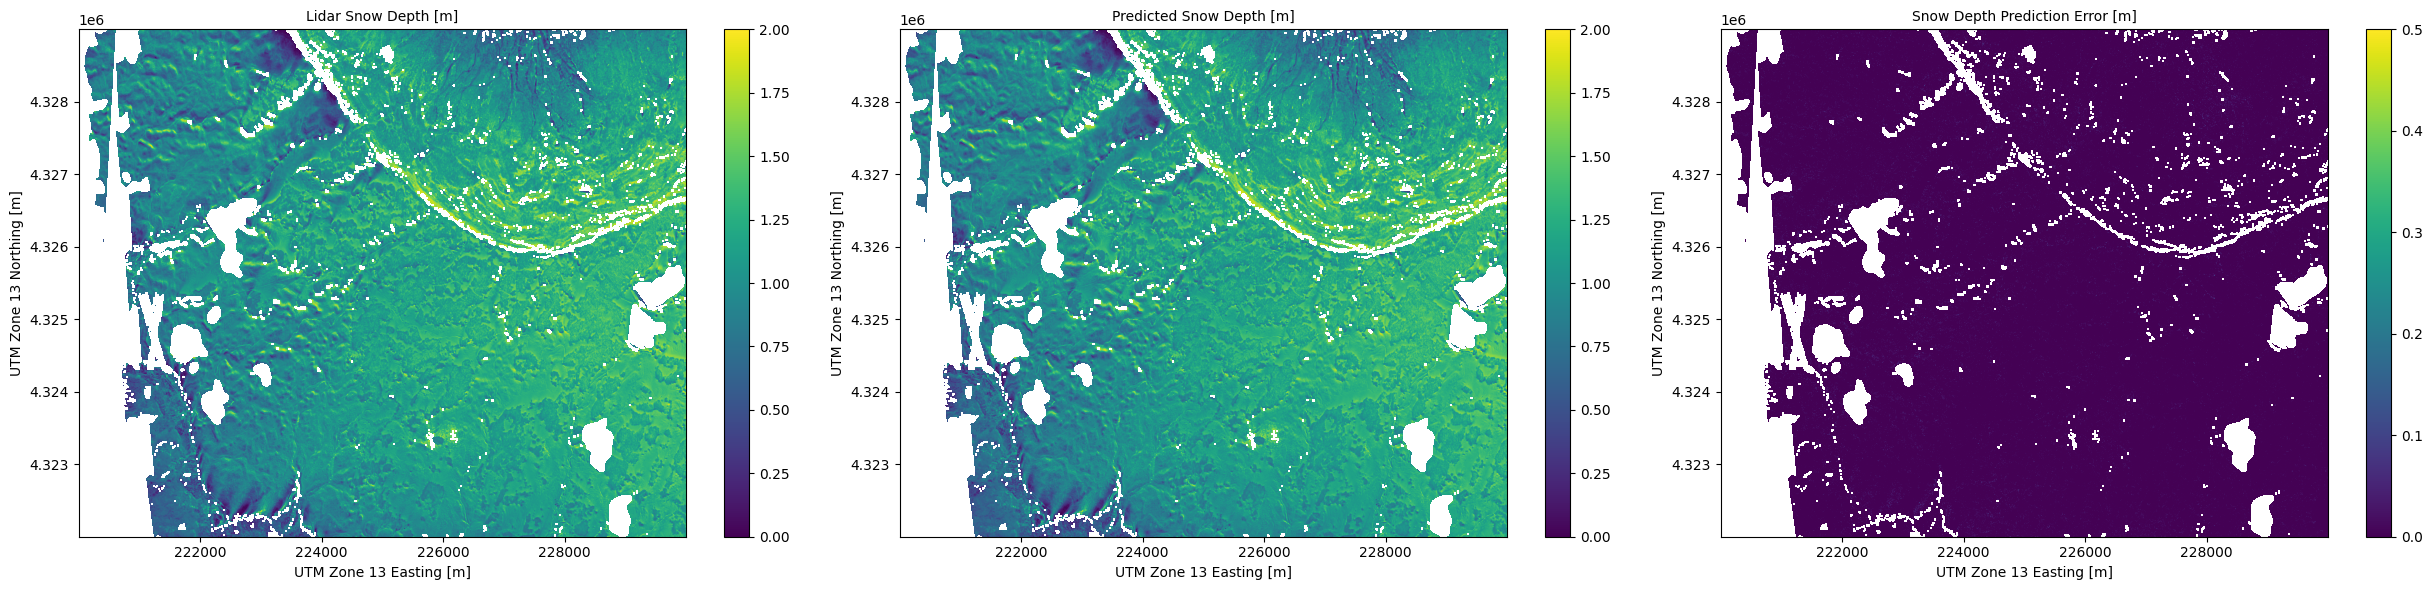

In [13]:
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)

plot_var(
    variable=true_depth, 
    var_name='Lidar Snow Depth [m]', 
    clims=(0, 2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
)

plt.subplot(1,3,2)

plot_var(
    variable=predicted_depth, 
    var_name='Predicted Snow Depth [m]', 
    clims=(0, 2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
)

plt.subplot(1,3,3)

plot_var(
    variable=depth_error, 
    var_name='Snow Depth Prediction Error [m]', 
    clims=(0, 0.5), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
)

plt.tight_layout()